In [1]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
shap.initjs()

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import SSWARM

## Notebook with the implementation of the SSWARM algorithm for finding shapley values

In [2]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 100
TARGET_NAME = 'TARGET'
np.random.seed(RANDOM_STATE)

In [3]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

### Binary

In [4]:
%%time
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)
data = pd.read_csv(DATASET_DIR + DATASET_NAME)

train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

task = Task('binary')

roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

Data is splitted. Parts sizes: train_data = (8000, 122), test_data = (2000, 122)
CPU times: user 3min 50s, sys: 26.6 s, total: 4min 16s
Wall time: 1min 8s


#### 
**Get shapley values of the model**

In [5]:
X_test = test_data.drop(columns=roles["target"]).reset_index(drop=True)
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [6]:
%%time
shap_values = explainer.shap_values(X_test, n_jobs=N_THREADS)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.83it/s]


CPU times: user 1min 29s, sys: 6.59 s, total: 1min 35s
Wall time: 1min 15s


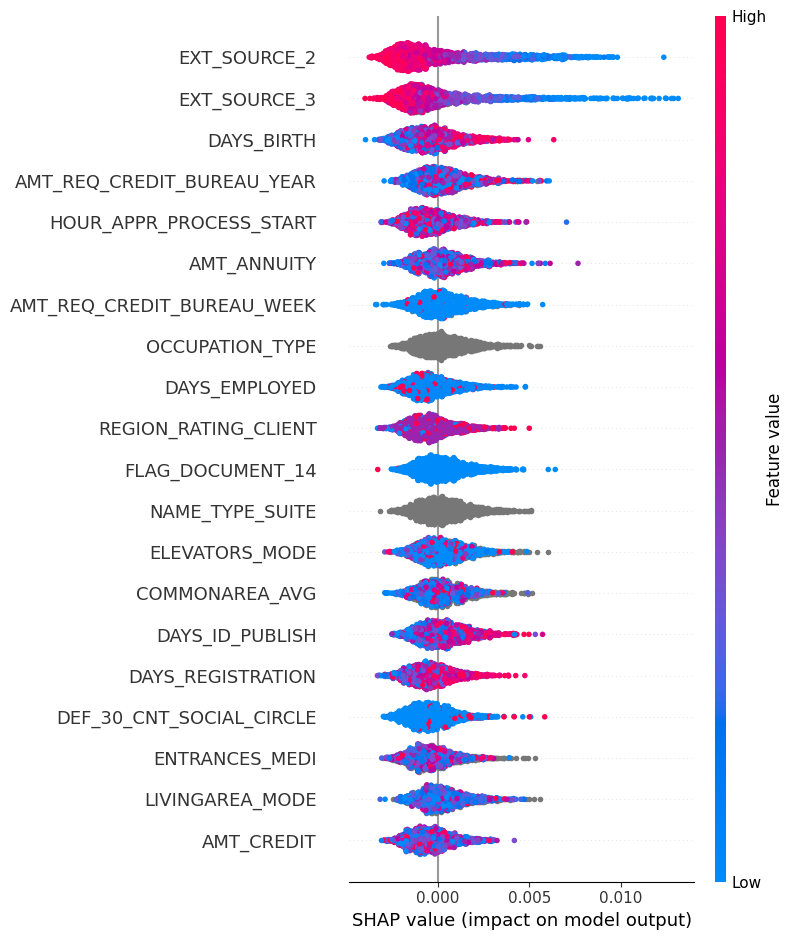

In [7]:
shap.summary_plot(shap_values[-1], X_test)

In [8]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[:1])

In [9]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[:1])

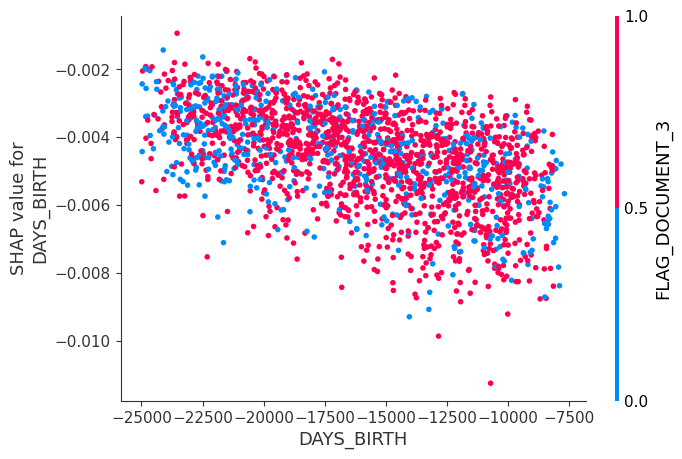

In [10]:
shap.dependence_plot("DAYS_BIRTH", shap_values[0], X_test, interaction_index="FLAG_DOCUMENT_3")

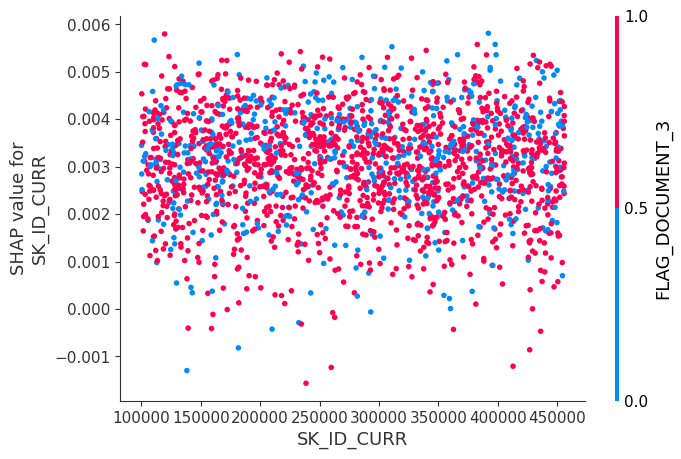

In [11]:
# shapley values for SK_ID_CURR look random and chaotic and are very close to zero
shap.dependence_plot("SK_ID_CURR", shap_values[0], X_test, interaction_index="FLAG_DOCUMENT_3")

## Regression

In [12]:
data = pd.read_csv('https://raw.githubusercontent.com/reneemarama/aiming_high_in_aimes/master/datasets/train.csv')

In [13]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

task = Task('reg', loss='mae', metric='mae')
roles = {
    'target': 'SalePrice',
    'drop': ['Id', 'PID']
}
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

Data is splitted. Parts sizes: train_data = (1640, 81), test_data = (411, 81)


#### 
**Get shapley values of the model**

In [14]:
X_test = test_data.drop(columns=roles["target"]).reset_index(drop=True)
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [15]:
%%time
shap_values = explainer.shap_values(X_test, n_jobs=N_THREADS)

1742it [00:35, 49.32it/s]                                                                                              


CPU times: user 3min 5s, sys: 3.03 s, total: 3min 8s
Wall time: 36.2 s


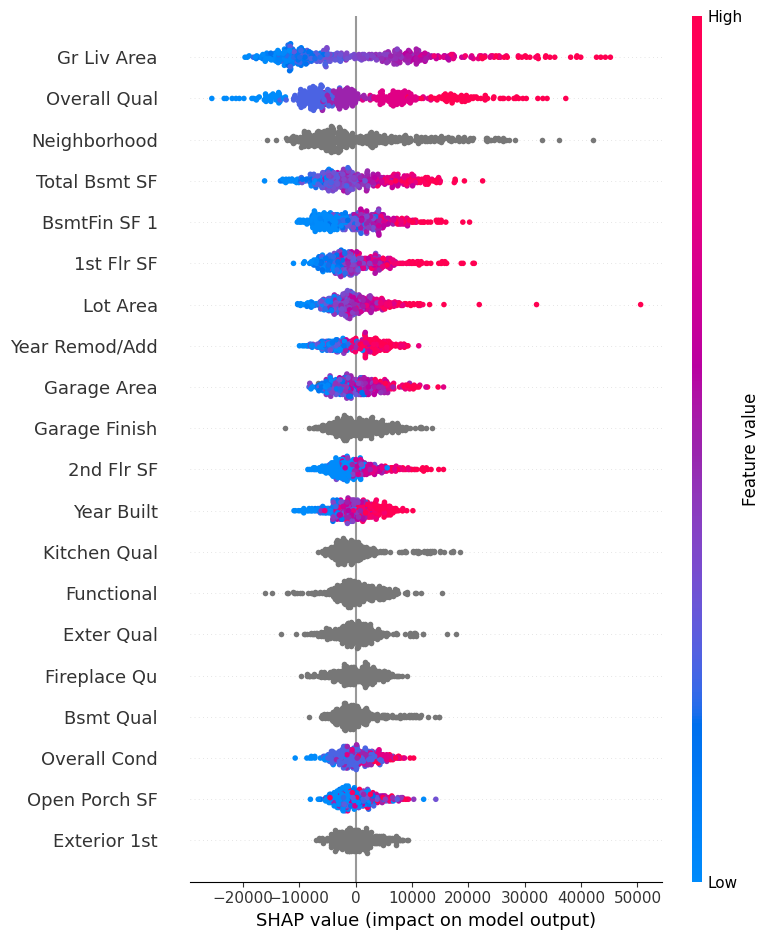

In [16]:
shap.summary_plot(shap_values, X_test)

In [19]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [20]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[:1])

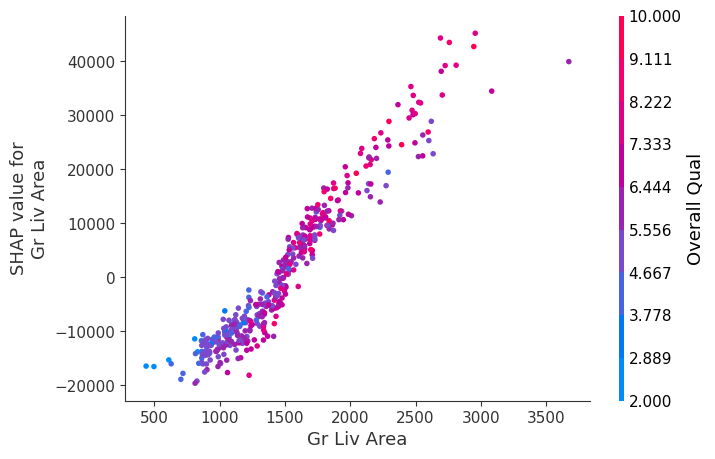

In [21]:
shap.dependence_plot("Gr Liv Area", shap_values, X_test, interaction_index="Overall Qual")

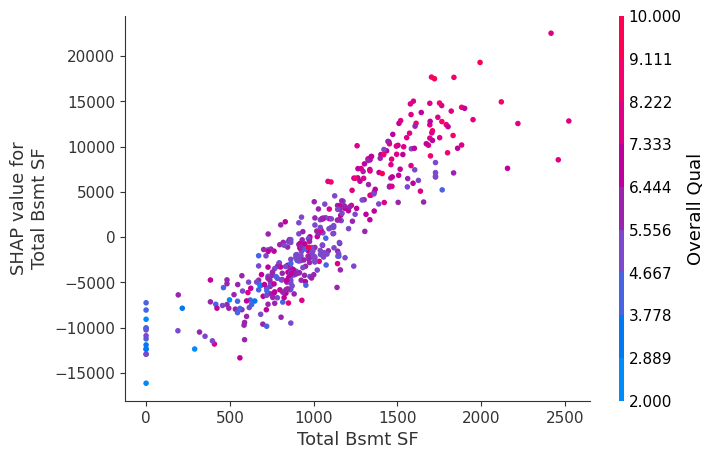

In [22]:
shap.dependence_plot("Total Bsmt SF", shap_values, X_test, interaction_index="Overall Qual")

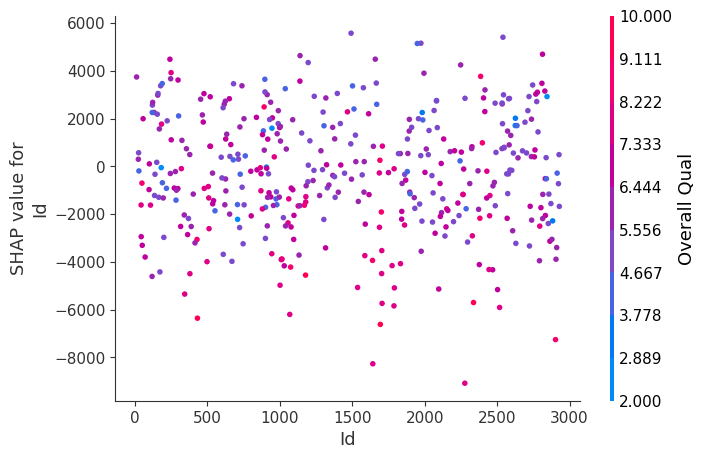

In [23]:
shap.dependence_plot("Id", shap_values, X_test, interaction_index="Overall Qual")

## Multiclass

In [24]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

data = pd.read_csv(
    ZipFile(
        BytesIO(
            urlopen(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip"
            ).read()
        )
    ).open('Frogs_MFCCs.csv')
)

train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,        
    shuffle=True, 
    random_state=RANDOM_STATE   
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')


task = Task('multiclass')
roles = {
    'target': 'Species',
    'drop': ['RecordID'] 
    
}

Data is splitted. Parts sizes: train_data = (5756, 26), test_data = (1439, 26)


In [25]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 0)

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


#### 
**Get shapley values of the model**

In [27]:
X_test = test_data.drop(columns=roles["target"]).reset_index(drop=True)
explainer = SSWARM(automl, random_state=RANDOM_STATE)

In [28]:
%%time
shap_values = explainer.shap_values(X_test, n_jobs=N_THREADS)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.85it/s]


CPU times: user 6min 14s, sys: 2.74 s, total: 6min 17s
Wall time: 24.9 s


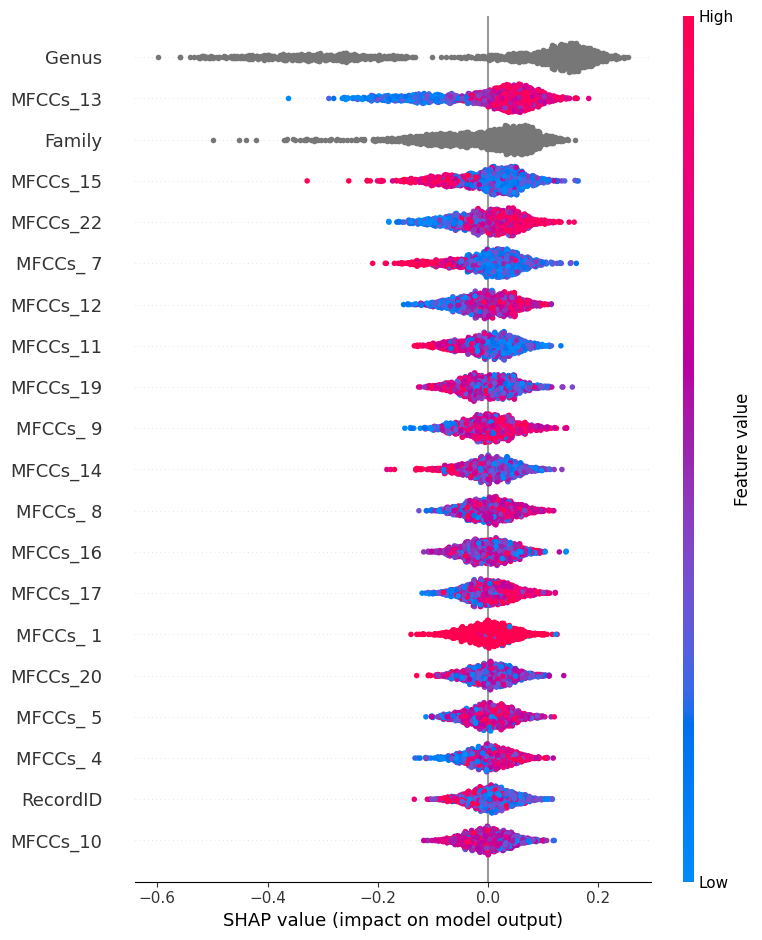

In [29]:
shap.summary_plot(shap_values[0], X_test)

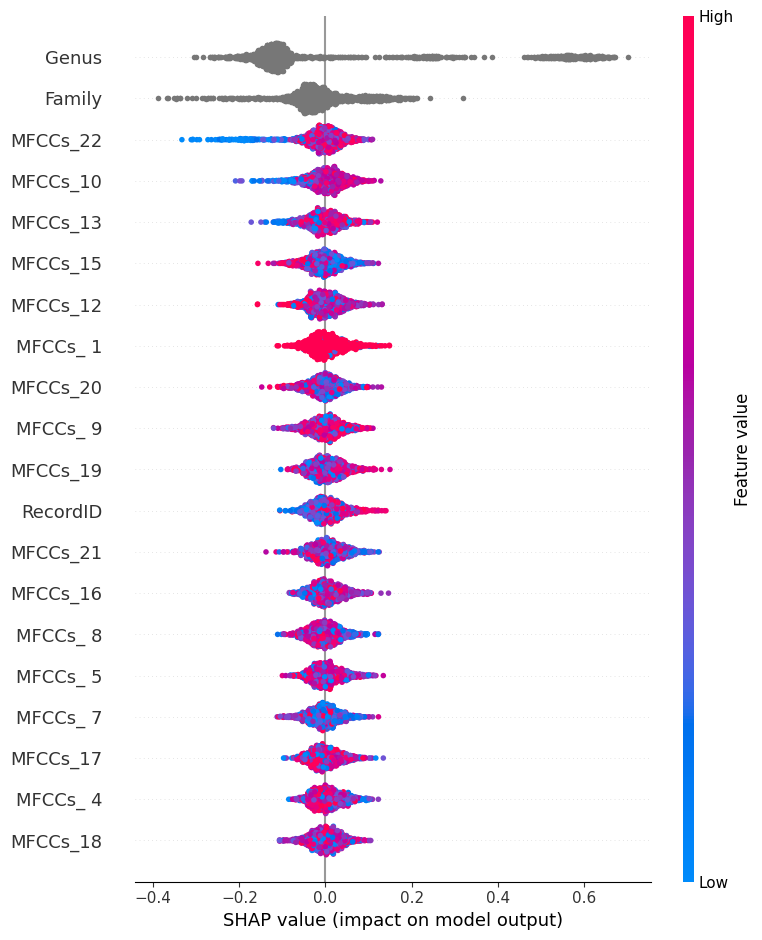

In [30]:
shap.summary_plot(shap_values[1], X_test)

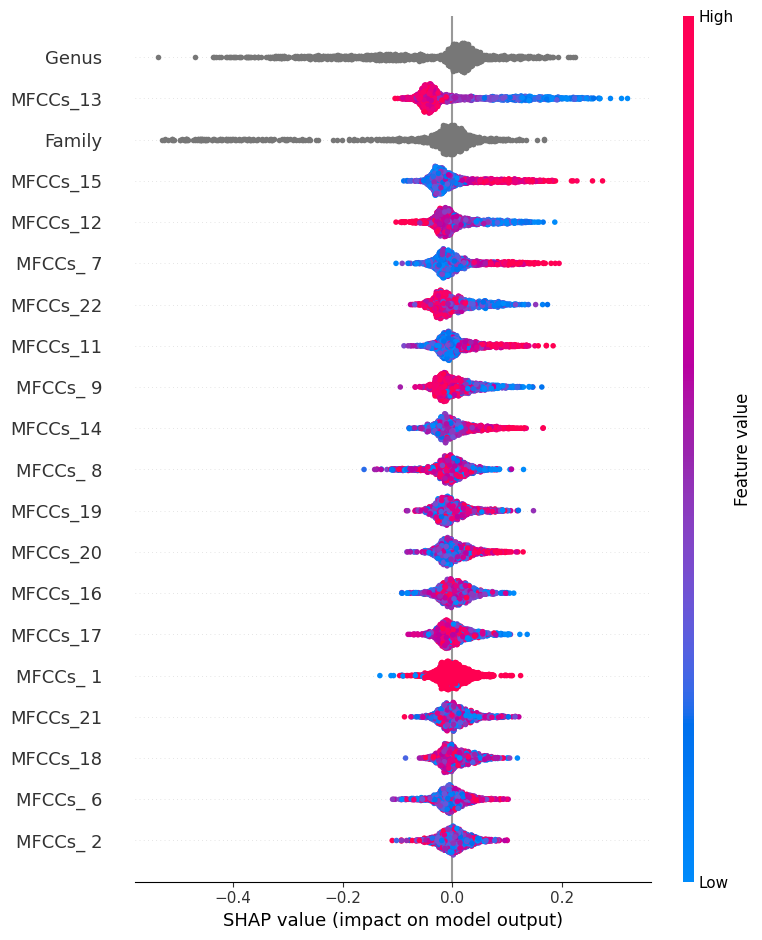

In [31]:
shap.summary_plot(shap_values[2], X_test)

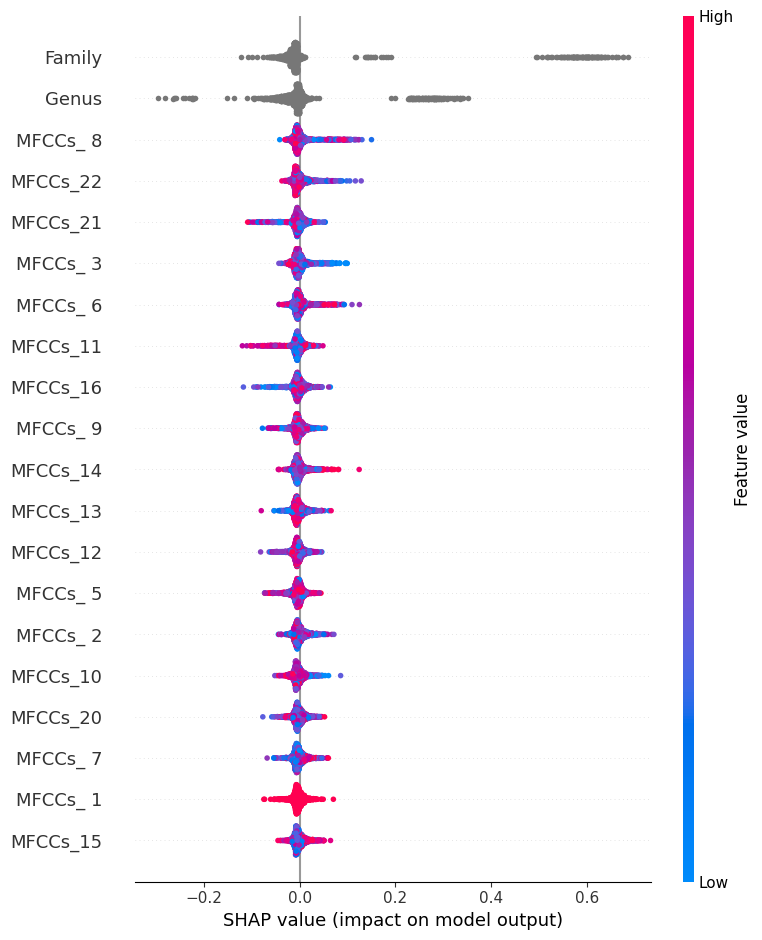

In [32]:
shap.summary_plot(shap_values[3], X_test)

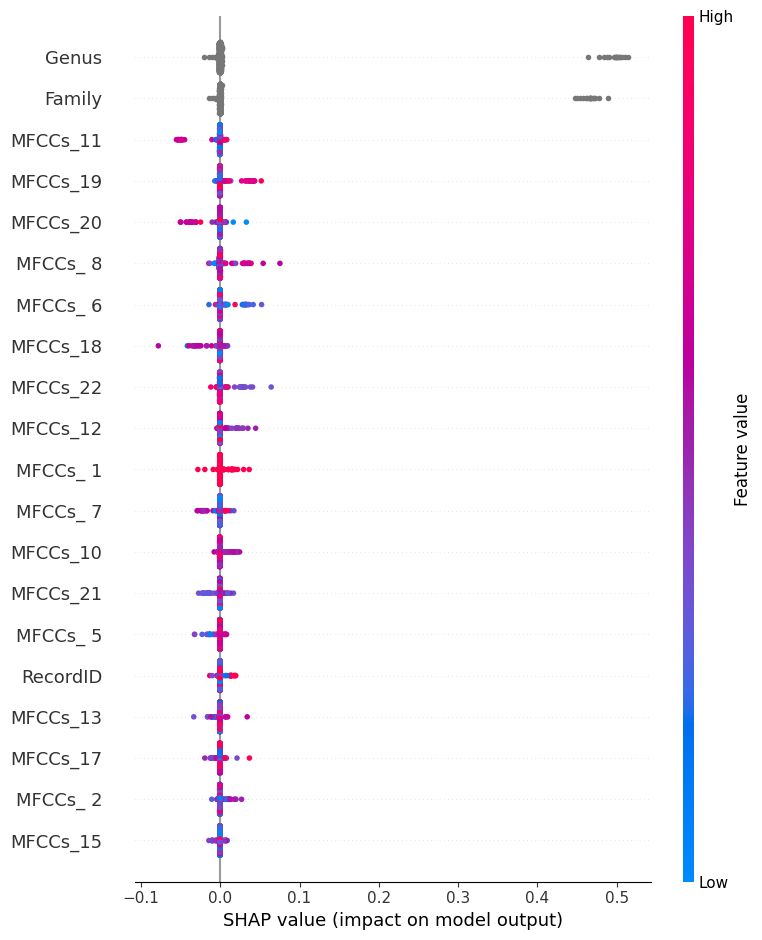

In [33]:
shap.summary_plot(shap_values[9], X_test)

In [34]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[:1])

In [35]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[:1])

In [36]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X_test.iloc[:1])

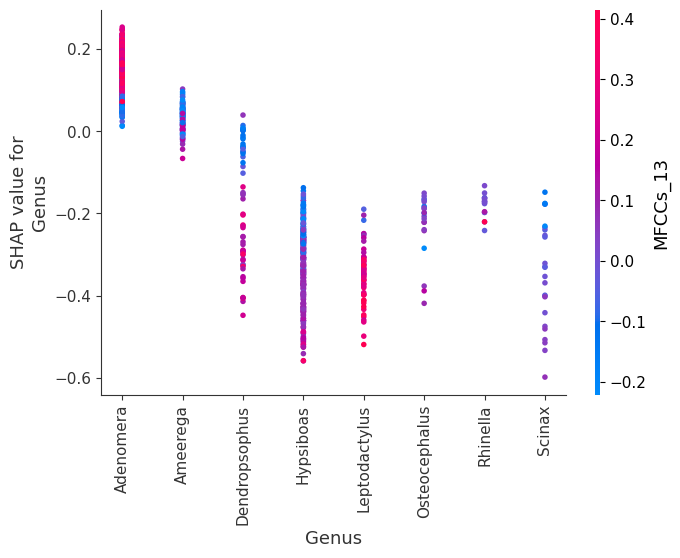

In [37]:
shap.dependence_plot("Genus", shap_values[0], X_test)

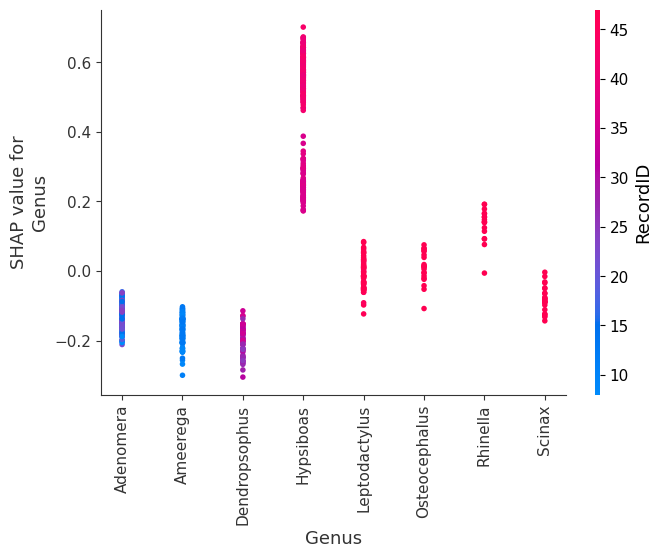

In [38]:
shap.dependence_plot("Genus", shap_values[1], X_test)

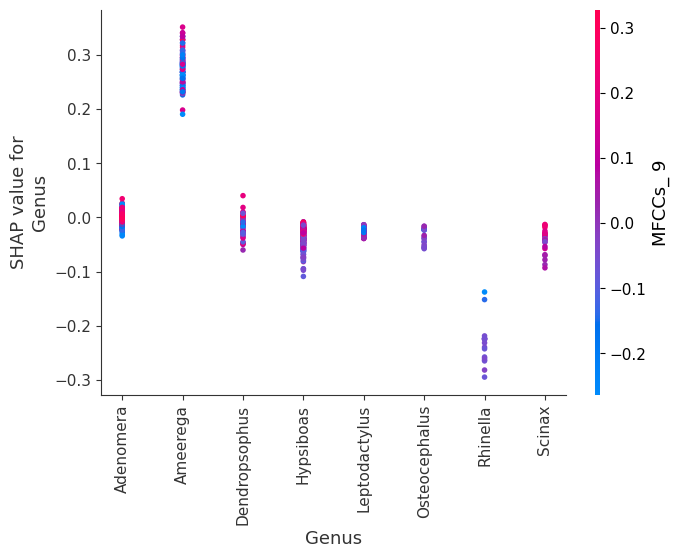

In [39]:
shap.dependence_plot("Genus", shap_values[3], X_test)

In [ ]:
shap.dependence_plot("MFCCs_13", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("RecordID", shap_values[3], X_test)